# Implementation of Vector Quantized Variational AutoEncoder (VQ-VAE)


## Step 1. Import Library

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Step 2. Set Hyperparameters

In [2]:
batch_size = 128
embedding_dim = 16
num_embeddings = 128

epochs = 50
print_freq = 100

lr = 1e-3

## Step 3. Load Dataset

In [3]:
transform=transforms.Compose([
    transforms.ToTensor(),
])

dataset1 = datasets.MNIST('~/datasets', train=True, download=True,
                       transform=transform)
dataset2 = datasets.MNIST('~/datasets', train=False,
                       transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

# compute the variance of the whole training set to normalise the Mean Squared Error
train_images = []
for images, labels in train_loader:
    train_images.append(images)
train_images = torch.cat(train_images, dim=0)
train_data_variance = torch.var(train_images)

## Step 4. Define Model: Vector Quantized Variational AutoEncoder (VQ-VAE)

### A. Embedding Space (Codebook)

In [4]:
class VectorQuantizer(nn.Module):
    """
    VQ-VAE layer: Input any tensor to be quantized. 
    Args:
        embedding_dim (int): the dimensionality of the tensors in the
          quantized space. Inputs to the modules must be in this format as well.
        num_embeddings (int): the number of vectors in the quantized space.
        commitment_cost (float): scalar which controls the weighting of the loss terms (see
          equation 4 in the paper - this variable is Beta).
    """
    def __init__(self, embedding_dim, num_embeddings, commitment_cost):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        
        # initialize embeddings
        self.embeddings = nn.Embedding(self.num_embeddings, self.embedding_dim)
        
    def forward(self, x):
        # [B, C, H, W] -> [B, H, W, C]
        x = x.permute(0, 2, 3, 1).contiguous() # change the position of dimensions
        # [B, H, W, C] -> [BHW, C]
        flat_x = x.reshape(-1, self.embedding_dim)
        
        encoding_indices = self.get_code_indices(flat_x)
        quantized = self.quantize(encoding_indices)
        quantized = quantized.view_as(x) # [B, H, W, C]
        
        if not self.training:
            quantized = quantized.permute(0, 3, 1, 2).contiguous() # [B, C, H, W]
            return quantized
        
        # embedding loss: move the embeddings towards the encoder's output
        embedding_loss = F.mse_loss(quantized, x.detach())
        # commitment loss
        e_latent_loss = F.mse_loss(x, quantized.detach())
        commitment_loss = self.commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = x + (quantized - x).detach()
        
        quantized = quantized.permute(0, 3, 1, 2).contiguous()
        return quantized, embedding_loss, commitment_loss
    
    def get_code_indices(self, flat_x):
        # compute L2 distance
        distances = (
            torch.sum(flat_x ** 2, dim=1, keepdim=True) +
            torch.sum(self.embeddings.weight ** 2, dim=1) - 
            2. * torch.matmul(flat_x, self.embeddings.weight.t())
        ) # [N, M]
        encoding_indices = torch.argmin(distances, dim=1) # [N,]
        return encoding_indices
    
    def quantize(self, encoding_indices):
        """Returns embedding tensor for a batch of indices."""
        return self.embeddings(encoding_indices)      

### B. Encoder

In [5]:
class Encoder(nn.Module):
    """Encoder of VQ-VAE"""
    
    def __init__(self, in_dim=3, latent_dim=16):
        super().__init__()
        self.in_dim = in_dim
        self.latent_dim = latent_dim
        
        self.convs = nn.Sequential(
            nn.Conv2d(in_dim, 32, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, latent_dim, 1),
        )
        
    def forward(self, x):
        return self.convs(x)

### C. Decoder

In [6]:
class Decoder(nn.Module):
    """Decoder of VQ-VAE"""
    
    def __init__(self, out_dim=1, latent_dim=16):
        super().__init__()
        self.out_dim = out_dim
        self.latent_dim = latent_dim
        
        self.convs = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, out_dim, 3, padding=1),
        )
        
    def forward(self, x):
        return self.convs(x)

### D. VQ-VAE

In [7]:
class VQVAE(nn.Module):
    """VQ-VAE"""
    
    def __init__(self, in_dim, embedding_dim, num_embeddings, data_variance, 
                 commitment_cost=0.25):
        super().__init__()
        self.in_dim = in_dim
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.data_variance = data_variance
        
        self.encoder = Encoder(in_dim, embedding_dim)
        self.vq_layer = VectorQuantizer(embedding_dim, num_embeddings, commitment_cost)
        self.decoder = Decoder(in_dim, embedding_dim)
        
    def forward(self, x):
        z = self.encoder(x)
        if not self.training:
            e = self.vq_layer(z)
            x_recon = self.decoder(e)
            return e, x_recon
        
        e, embedding_loss, commitment_loss = self.vq_layer(z)
        x_recon = self.decoder(e)
        
        recon_loss = F.mse_loss(x_recon, x) / self.data_variance
        
        return e, recon_loss, embedding_loss, commitment_loss  

In [8]:
model = VQVAE(1, embedding_dim, num_embeddings, train_data_variance)
model = model.cuda()

## Step 5. Define Optimizer

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

## Step 6. Train

In [10]:
# train VQ-VAE

print("Start training VQ-VAE...")

model.train()

recon_loss_list = []
embedding_loss_list = []
commitment_loss_list = []
loss_list = []

for epoch in range(epochs):
    rec_l = 0
    emb_l = 0
    com_l = 0
    overall_loss = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images - 0.5 # normalize to [-0.5, 0.5]
        images = images.cuda()
        e, recon_loss, embedding_loss, commitment_loss = model(images)
        rec_l += recon_loss.item()
        emb_l += embedding_loss.item()
        com_l += commitment_loss.item()
        loss = recon_loss + embedding_loss + commitment_loss
        overall_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i + 1) % print_freq == 0 or (i + 1) == len(train_loader):
             print("epoch:", epoch + 1, "  step:", i + 1, "   recon_loss:", recon_loss.item(), 
              "\n\t\t\tcommit_loss: ", commitment_loss.item(), 
              "\n\t\t\tembedding loss: ", embedding_loss.item(), 
              "\n\t\t\ttotal_loss: ", loss.item())

    recon_loss_list.append(rec_l)
    embedding_loss_list.append(emb_l)
    commitment_loss_list.append(com_l)
    loss_list.append(overall_loss)
                
print("Finish!!")               

Start training VQ-VAE...
epoch: 1   step: 100    recon_loss: 0.3003235161304474 
			commit_loss:  0.17875804007053375 
			embedding loss:  0.715032160282135 
			total_loss:  1.1941137313842773
epoch: 1   step: 200    recon_loss: 0.17561441659927368 
			commit_loss:  0.14298371970653534 
			embedding loss:  0.5719348788261414 
			total_loss:  0.8905330300331116
epoch: 1   step: 300    recon_loss: 0.12561210989952087 
			commit_loss:  0.1017996147274971 
			embedding loss:  0.4071984589099884 
			total_loss:  0.6346101760864258
epoch: 1   step: 400    recon_loss: 0.10410338640213013 
			commit_loss:  0.07636929303407669 
			embedding loss:  0.30547717213630676 
			total_loss:  0.485949844121933
epoch: 1   step: 469    recon_loss: 0.09885252267122269 
			commit_loss:  0.07519177347421646 
			embedding loss:  0.30076709389686584 
			total_loss:  0.4748113751411438
epoch: 2   step: 100    recon_loss: 0.09208530932664871 
			commit_loss:  0.06787142902612686 
			embedding loss:  0.2714857161

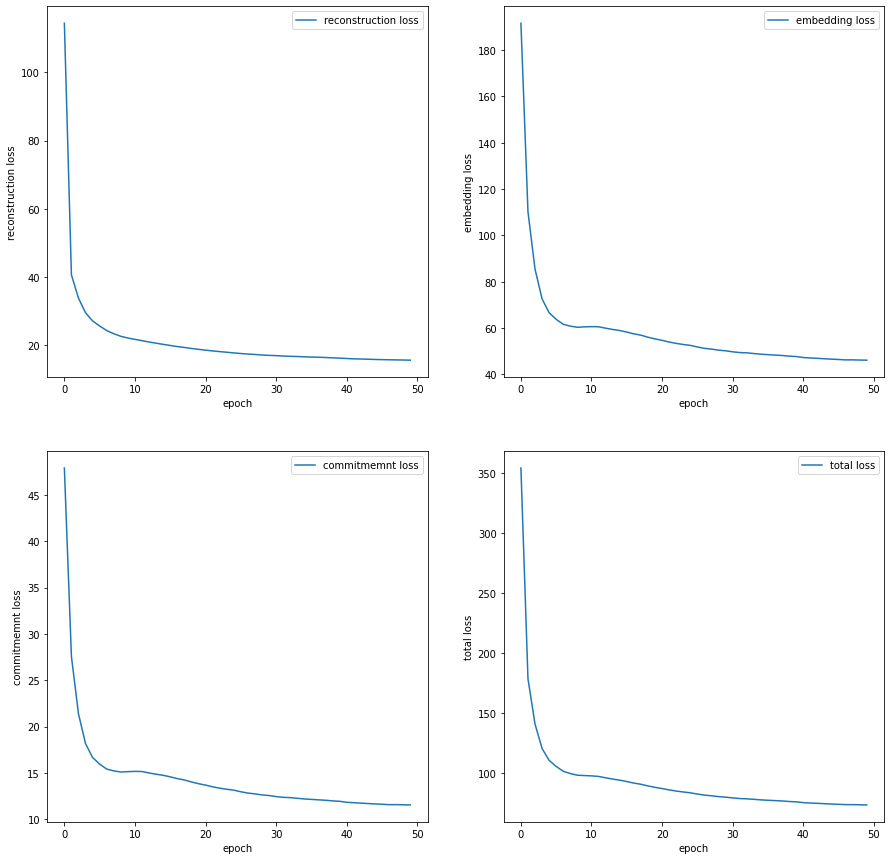

In [23]:
plt.figure(figsize=(15, 15))

plt.subplot(2,2,1)
plt.plot(recon_loss_list, label= 'reconstruction loss')
plt.xlabel("epoch")
plt.ylabel('reconstruction loss')
plt.legend()

plt.subplot(2,2,2)
plt.plot(embedding_loss_list, label = 'embedding loss')
plt.xlabel("epoch")
plt.ylabel('embedding loss')
plt.legend()

plt.subplot(2,2,3)
plt.plot(commitment_loss_list, label = 'commitmemnt loss')
plt.xlabel("epoch")
plt.ylabel('commitmemnt loss')
plt.legend()

plt.subplot(2,2,4)
plt.plot(loss_list, label = 'total loss')
plt.xlabel("epoch")
plt.ylabel('total loss')
plt.legend()

## Step 7. Reconstruct Images

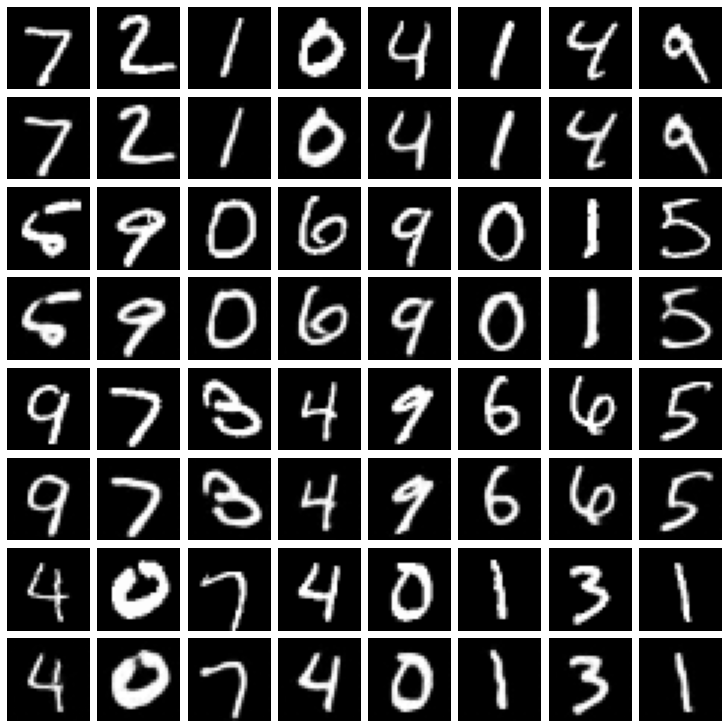

In [11]:
# reconstruct images

test_loader_iter = iter(test_loader)
images, labels = next(test_loader_iter)

n_samples = 32
images = images[:n_samples]

model.eval()

norm_images = (images - 0.5).cuda()
with torch.inference_mode():
    e, recon_images = model(norm_images)

recon_images = np.array(np.clip((recon_images + 0.5).cpu().numpy(), 0., 1.) * 255, dtype=np.uint8)
ori_images = np.array(images.numpy() * 255, dtype=np.uint8)

recon_images = recon_images.reshape(4, 8, 28, 28)
ori_images = ori_images.reshape(4, 8, 28, 28)

fig = plt.figure(figsize=(10, 10), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
for n_row in range(4):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row * 2, n_col])
        f_ax.imshow(ori_images[n_row, n_col], cmap="gray")
        f_ax.axis("off")
        f_ax = fig.add_subplot(gs[n_row * 2 + 1, n_col])
        f_ax.imshow(recon_images[n_row, n_col], cmap="gray")
        f_ax.axis("off")

## Step 8. Visualize Latent Features

<AxesSubplot:xlabel='x1', ylabel='x2'>

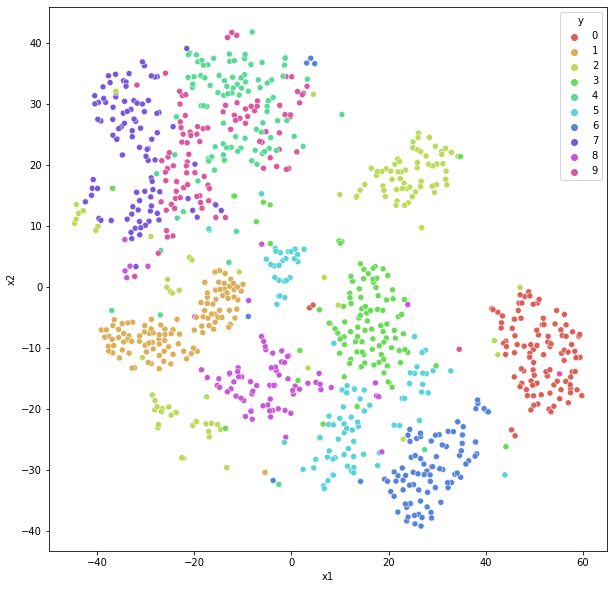

In [13]:
## visualize latent features

latent_zs = []
targets = []
for i, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        with torch.no_grad():
            e = model.encoder(images)

        latent_zs.append(e.cpu().numpy())
        targets.append(labels.numpy())
latent_zs = np.concatenate(latent_zs, 0)
targets = np.concatenate(targets, 0)

n_samples = 1000
sample_idxs = np.random.permutation(len(targets))[:n_samples]

latent_zs = latent_zs[sample_idxs]
latent_zs = latent_zs.reshape(n_samples, -1)

targets = targets[sample_idxs]

zs_reduced = TSNE(n_components=2, random_state=2022).fit_transform(latent_zs)

tsne_data = pd.DataFrame({
    "x1": zs_reduced[:,0],
    "x2": zs_reduced[:,1],
    "y": targets})

plt.figure(figsize=(10, 10))
sns.scatterplot(
    x="x1", y="x2",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=tsne_data,
    legend="full",
    alpha=1.0
)   

## Step 9. Generate New Images

In [24]:
# get encode_indices of training images
train_indices = []
for images, labels in train_loader:
    images = images - 0.5 # normalize to [-0.5, 0.5]
    images = images.cuda()
    with torch.inference_mode():
        z = model.encoder(images) # [B, C, H, W]
        b, c, h, w = z.size()
        # [B, C, H, W] -> [B, H, W, C]
        z = z.permute(0, 2, 3, 1).contiguous()
        # [B, H, W, C] -> [BHW, C]
        flat_z = z.reshape(-1, c)
        encoding_indices = model.vq_layer.get_code_indices(flat_z) # [BHW,]
        encoding_indices = encoding_indices.reshape(b, h, w)
        train_indices.append(encoding_indices.cpu())

In [25]:
# train PixelCNN to generate new images

class MaskedConv2d(nn.Conv2d):
    """
    Implements a conv2d with mask applied on its weights.
    
    Args:
        mask (torch.Tensor): the mask tensor.
        in_channels (int) – Number of channels in the input image.
        out_channels (int) – Number of channels produced by the convolution.
        kernel_size (int or tuple) – Size of the convolving kernel
    """
    
    def __init__(self, mask, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)
        self.register_buffer('mask', mask[None, None])
        
    def forward(self, x):
        self.weight.data *= self.mask # mask weights
        return super().forward(x)
    

class VerticalStackConv(MaskedConv2d):

    def __init__(self, mask_type, in_channels, out_channels, kernel_size, **kwargs):
        # Mask out all pixels below. For efficiency, we could also reduce the kernel
        # size in height (k//2, k), but for simplicity, we stick with masking here.
        self.mask_type = mask_type
        
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        mask = torch.zeros(kernel_size)
        mask[:kernel_size[0]//2, :] = 1.0
        if self.mask_type == "B":
            mask[kernel_size[0]//2, :] = 1.0

        super().__init__(mask, in_channels, out_channels, kernel_size, **kwargs)

class HorizontalStackConv(MaskedConv2d):

    def __init__(self, mask_type, in_channels, out_channels, kernel_size, **kwargs):
        # Mask out all pixels on the left. Note that our kernel has a size of 1
        # in height because we only look at the pixel in the same row.
        self.mask_type = mask_type
        
        if isinstance(kernel_size, int):
            kernel_size = (1, kernel_size)
        assert kernel_size[0] == 1
        if "padding" in kwargs:
            if isinstance(kwargs["padding"], int):
                kwargs["padding"] = (0, kwargs["padding"])
        
        mask = torch.zeros(kernel_size)
        mask[:, :kernel_size[1]//2] = 1.0
        if self.mask_type == "B":
            mask[:, kernel_size[1]//2] = 1.0

        super().__init__(mask, in_channels, out_channels, kernel_size, **kwargs)

class GatedMaskedConv(nn.Module):

    def __init__(self, in_channels, kernel_size=3, dilation=1):
        """
        Gated Convolution block implemented the computation graph shown above.
        """
        super().__init__()
        
        padding = dilation * (kernel_size - 1) // 2
        self.conv_vert = VerticalStackConv("B", in_channels, 2*in_channels, kernel_size, padding=padding,
                                          dilation=dilation)
        self.conv_horiz = HorizontalStackConv("B", in_channels, 2*in_channels, kernel_size, padding=padding,
                                             dilation=dilation)
        self.conv_vert_to_horiz = nn.Conv2d(2*in_channels, 2*in_channels, kernel_size=1)
        self.conv_horiz_1x1 = nn.Conv2d(in_channels, in_channels, kernel_size=1)

    def forward(self, v_stack, h_stack):
        # Vertical stack (left)
        v_stack_feat = self.conv_vert(v_stack)
        v_val, v_gate = v_stack_feat.chunk(2, dim=1)
        v_stack_out = torch.tanh(v_val) * torch.sigmoid(v_gate)

        # Horizontal stack (right)
        h_stack_feat = self.conv_horiz(h_stack)
        h_stack_feat = h_stack_feat + self.conv_vert_to_horiz(v_stack_feat)
        h_val, h_gate = h_stack_feat.chunk(2, dim=1)
        h_stack_feat = torch.tanh(h_val) * torch.sigmoid(h_gate)
        h_stack_out = self.conv_horiz_1x1(h_stack_feat)
        h_stack_out = h_stack_out + h_stack

        return v_stack_out, h_stack_out

class GatedPixelCNN(nn.Module):
    
    def __init__(self, in_channels, channels, out_channels):
        super().__init__()
        
        # Initial first conv with mask_type A
        self.conv_vstack = VerticalStackConv("A", in_channels, channels, 3, padding=1)
        self.conv_hstack = HorizontalStackConv("A", in_channels, channels, 3, padding=1)
        # Convolution block of PixelCNN. use dilation instead of 
        # downscaling used in the encoder-decoder architecture in PixelCNN++
        self.conv_layers = nn.ModuleList([
            GatedMaskedConv(channels),
            GatedMaskedConv(channels, dilation=2),
            GatedMaskedConv(channels)
        ])
        
        # Output classification convolution (1x1)
        self.conv_out = nn.Conv2d(channels, out_channels, kernel_size=1)
        
    def forward(self, x):
        # first convolutions
        v_stack = self.conv_vstack(x)
        h_stack = self.conv_hstack(x)
        # Gated Convolutions
        for layer in self.conv_layers:
            v_stack, h_stack = layer(v_stack, h_stack)
        # 1x1 classification convolution
        # Apply ELU before 1x1 convolution for non-linearity on residual connection
        out = self.conv_out(F.elu(h_stack))
        return out


In [26]:
epochs = 20

pixelcnn = GatedPixelCNN(num_embeddings, 128, num_embeddings)
pixelcnn = pixelcnn.cuda()

optimizer = torch.optim.Adam(pixelcnn.parameters(), lr=1e-3)

# train pixelcnn
print_freq = 500
for epoch in range(epochs):
    print("Start training epoch {}".format(epoch,))
    for i, (indices) in enumerate(train_indices):
        indices = indices.cuda()
        one_hot_indices = F.one_hot(indices, num_embeddings).float().permute(0, 3, 1, 2).contiguous()
        
        outputs = pixelcnn(one_hot_indices)
        
        loss = F.cross_entropy(outputs, indices)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i + 1) % print_freq == 0 or (i + 1) == len(train_loader):
            print("\t [{}/{}]: loss {}".format(i, len(train_loader), loss.item())) 

Start training epoch 0
	 [468/469]: loss 1.2534481287002563
Start training epoch 1
	 [468/469]: loss 1.158263921737671
Start training epoch 2
	 [468/469]: loss 1.1218984127044678
Start training epoch 3
	 [468/469]: loss 1.0998497009277344
Start training epoch 4
	 [468/469]: loss 1.084914207458496
Start training epoch 5
	 [468/469]: loss 1.0745093822479248
Start training epoch 6
	 [468/469]: loss 1.0659706592559814
Start training epoch 7
	 [468/469]: loss 1.0590648651123047
Start training epoch 8
	 [468/469]: loss 1.0543972253799438
Start training epoch 9
	 [468/469]: loss 1.0491890907287598
Start training epoch 10
	 [468/469]: loss 1.0407670736312866
Start training epoch 11
	 [468/469]: loss 1.0325677394866943
Start training epoch 12
	 [468/469]: loss 1.0253206491470337
Start training epoch 13
	 [468/469]: loss 1.0185283422470093
Start training epoch 14
	 [468/469]: loss 1.0114384889602661
Start training epoch 15
	 [468/469]: loss 1.0032947063446045
Start training epoch 16
	 [468/469]:

In [27]:
# Create an empty array of priors.
n_samples = 64
prior_size = (7, 7) # h, w
priors = torch.zeros((n_samples,) + prior_size, dtype=torch.long).cuda()

# use pixelcnn to generate priors
pixelcnn.eval()

# Iterate over the priors because generation has to be done sequentially pixel by pixel.
for row in range(prior_size[0]):
    for col in range(prior_size[1]):
        # Feed the whole array and retrieving the pixel value probabilities for the next
        # pixel.
        with torch.inference_mode():
            one_hot_priors = F.one_hot(priors, num_embeddings).float().permute(0, 3, 1, 2).contiguous()
            logits = pixelcnn(one_hot_priors)
            probs = F.softmax(logits[:, :, row, col], dim=-1)
            # Use the probabilities to pick pixel values and append the values to the priors.
            priors[:, row, col] = torch.multinomial(probs, num_samples=1).squeeze(dim=-1)

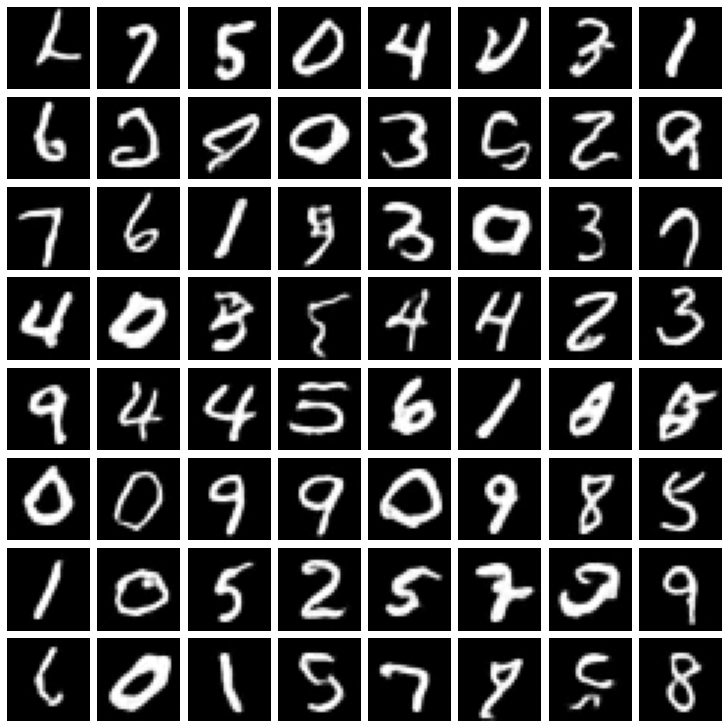

In [28]:
# Perform an embedding lookup and Generate new images
with torch.inference_mode():
    z = model.vq_layer.quantize(priors)
    z = z.permute(0, 3, 1, 2).contiguous()
    pred = model.decoder(z)

generated_samples = np.array(np.clip((pred + 0.5).cpu().numpy(), 0., 1.) * 255, dtype=np.uint8)
generated_samples = generated_samples.reshape(8, 8, 28, 28)

fig = plt.figure(figsize=(10, 10), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_samples[n_row, n_col], cmap="gray")
        f_ax.axis("off")
